In [1]:
# This is the jupyter notebook of cosmo_Rate
# Version 1.0.0.0 - public release
# Details follow

In [2]:
#### importing libraries
# cosmology
from astropy.cosmology import Planck18 as Planck
import astropy.units as u
from astropy.cosmology import z_at_value
# plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# others
from math import erf
import sys
import numpy as np
import os
# this command prevents Python from multithreading (useful especiallfy for clusters!)
os.environ['MKL_NUM_THREADS'] = '1'
from tqdm import tqdm
from random import gauss
# important functions 
import cosmo_functions as cf
from scipy.interpolate import interp1d

In [3]:
#import cosmo_params_popIII_uncrt as par
import cosmo_params as par
#import cosmo_params_popII as par

In [4]:
# This parameter prevents outputs to be overwritten if you intend to parallelise the code
n_paral = par.n_paral

###########################################################
# Compact objects specificities (PopSynth / N-body)
# list of compact objects type
cb_class = par.cb_class 
# list of metallicity used from simulations, as float type, ascending order
Z_simulated = par.Z_simulated
formation_channel = par.formation_channel  # formation channel type (iso or dyn)
if formation_channel == 'iso':
    fbin = 0.5  # fraction of binaries, for 'iso' it must be either 50% or 40%. 
                # 40% when you comapare the isolated and dynamical formation channel
    fimf = 0.285 # correction for initial mass function. For 'iso' must be 0.285.
    fbin_save = int(100.0*fbin) # this is the fraction of binaries that appears in the file name.
elif formation_channel == 'dyn':
    fbin = 1.  # Dynamical binaries are alredy 40% of binaries. This parameter must be equal to 1
    fimf = 1.  # Dynamical binaries simulated the whole initial mass function. 
               # This parameter must be equal to 1
    fbin_save = 40  # this is the fraction of binaries that appears in the file name. 
                    # Dynamical binaries are alredy 40 % of binaries, as stated above
elif formation_channel == 'popIII':
    fbin=1.0
    fimf=1.0
    fbin_save = int(100.0*fbin) # this is the fraction of binaries that appears in the file name.
else:
    print("Please, select a formation chennle between 'iso', 'dyn' and 'popIII'")
    raise

# this parameter is used to select your astrophysical model and
# in naming the output catalog files (i.e values of alpha, SN model type...)
sim = par.sim
sim_name = par.sim_name
in_input_folder = '../astromodel/'
input_folder = in_input_folder+sim#+'/input_catalogs/'
extension = par.extension


In [5]:
###########################################################
# Definition of redshift bins. 
# you can choose between equally spaced in time (proper_time = True) 
# or in redshift (proper_time = False)
# the former has higher definition at lower redshift, 
# the latter the contrary
proper_time = par.proper_time
if proper_time == False:
    #bin_z = 0.1  # redshift bin width
    N_z_bins = par.N_z_bins 
    zMAX = par.zMAX # maximum redshift '15' for popII-I, '40' for popII
    zMIN = par.zMIN  # minimum redshift
    # histograms of redshift/time in descending order
    z_hist = np.linspace(zMAX, zMIN, N_z_bins)
    bin_save = 'False'
else:
    t_max_arr = par.t_max_arr #Gyr, this can be at most equal to the age of the Universe
    t_min_arr = par.t_min_arr #Gyr, this cannot be lower than 1e-3 Gyr
    N_t_bins = par.N_t_bins  # total numer of bins
    bin_t_proper = np.linspace(t_min_arr,t_max_arr,N_t_bins)
    z_hist = []
    for t in range(0,len(bin_t_proper)):
        z_hist.append(z_at_value(Planck.lookback_time, bin_t_proper[t]*u.Gyr) )
    # from high redshift to low redshift 
    z_hist = np.sort(np.concatenate([z_hist], axis = None))[::-1]
    zMAX = max(z_hist)
    zMIN = min(z_hist)
    bin_save = 'True'

In [6]:
##########################################################
# select the population of stars 
pop = par.pop
SFRD_model = par.SFRD_model

In [7]:
###########################################################
# Metallicity and Star formation rate specificities 

# Choose the model for average metallicity fit type 
metmod_type = par.metmod_type
# if you want to apply variations to the parameters provided by default, 
# keep in mind that every metallicity related quantity must be given in log-sun scale
# otherwise specifically stated 
if metmod_type == 'linear':
    met_slope_avg = -0.24 #from De Cia et al. 2018 
    met_inter_avg = 1.04 # from Gallazzi et al. 2008. 
                         #  It is applied a log to this value before inserting it in the metallicity evolution model.
    sigma_met = par.sigma_met  # value of the metallicity spread in log-sun-scale
    
    def metz(z, slope, intercept,sigma_met):
        # This function evaluates the mean metallicity evolution with redshift
        # -------------------------
        # z --> redshift
        # -------------------------
        Z_average = intercept+slope*z  # the result is in log-sun scale
        return Z_average
elif metmod_type == 'MandF2017':   
    met_slope_avg = -0.074 # from Madau and Fragos, 2017
    met_inter_avg = 10**(0.153)  # from Mafau and Fragos, 2017. 
                                # It is applied a log to this value before inserting it in the metallicity evolution model.
    sigma_met = par.sigma_met  # value of the metallicity spread in log-sun-scale
    
    def metz(z, slope, intercept, sigma_met):
        # This function evaluates the mean metallicity evolution with redshift
        # -------------------------
        # z --> redshift
        # -------------------------
        index = 1.34
        Z_average = intercept+slope*z**(index)
        return Z_average - np.log(10)/2*sigma_met**2
else:
    print("Please choose between the following models: linear, MandF2017")
    raise

# Definition of Solar metallicity
Z_sun = par.Z_sun  # 0.0153 from Cauffau et al. 2011  
                # 0.019 from Gallazzi et al. 2008

# Here you set if cosmo_Rate evaluates also the uncertainty through a Monte Carlo approach
N_iter = par.N_iter  # number of iteration to be done for evaluating the uncertainty. In any case, it must be at least one!
# 1000 iterations are enough to perform a robust estimation of the uncertainties

# metallicity
met_uncertainty = par.met_uncertainty # if 'Yes' the uncertainty due to metallicity will be computed
met_slope_sprd = par.met_slope_sprd   # 0.14 for linear metallicity model or 0.014 from 'MandF2017'
met_inter_sprd = par.met_inter_sprd   # from Gallazzi et al. 2008

# star formation rate option
sfr_uncertainty = par.sfr_uncertainty  # if 'Yes' the uncertainty due to sfr will be computed,
# spread over the normalisation value 
sfr_sprd = par.sfr_sprd  # from Madau & Dickinson 2017

In [8]:
###########################################################
# Catalogs of merging compact object options

catalogues_c = par.catalogues_c   # if 'Yes' merging compact object per redshift bin are produced
mrd_eval = par.mrd_eval # this option is to skip the evaluation of the merger rate density in case
                    # it has been already done in previous runs
    
# specify the redshift bins of which you want to have the catalogs printed
# WARNING: The code will search for the closest available redshift bin!
z_vect_cat_op = par.z_vect_cat_op #[20, 15, 10, 1] # if this option is set to False
                                       # the catalogs will be printed at every merger redshift    

    
# Specify what parameters cosmoRate will sample. The order of the parameter names must be exactly 
# the same as the order of the corresponding column in input_catalogs/
# delay time is sampled by default. 
# The number of parameters can be smaller than the total number of paramters given as input.
# Leave parameters = [] if in your catalogs you want just time-delay related parameters,
# i.e. merging redshift, formation redshift, delay time and progenitor star metallicity
parameters = par.parameters

# You can choose to sample from a different distirbution percentile than the median value.
# If you run cosmoRate for the first time, switch the uncertainty options on.
perc_input = par.perc_input  # Specify here the percentile value
# if the uncertainty has already been evaluated the code will look automatically 
# for the uncertianty output file.
# Specify here the uncertianty type you have already evaluated.
met_unc_cat = par.met_unc_cat
sfr_unc_cat = par.sfr_unc_cat
# You might have parallelized the code to evaluate the uncertainty
n_paral_cat = par.n_paral_cat  # total number of parallelized files,
# e.g. if they are file_0.dat and file_1.dat, n_paral_cat = 2
# number of iterations per each parallelization
N_iter_par = par.N_iter_par 
N_cat = par.N_cat  # number of CB per redshift bin
# number of significant decimal digits that are saved for each paramter of the merging compact binary catalogue. 
# This feature has been provided for saving memory space.
N_figures = par.N_figures

# sampling method for catalogs 
sampling = par.sampling

verbose = par.verbose

In [9]:
###########################################################
# Merger efficiency interpolation

# if 'Yes' the code evaluates the MRD using the merging efficiency interpolated from Z_simulated on Z_interpol
eta_interpol_c = par.eta_interpol_c 
# values of metallicity on which the code performs merging efficiency interpolation, as float, ascending order
Z_interpol = par.Z_interpol

In [10]:
# path where to write output file
path_out =in_input_folder+sim+par.path_out_out  # path to the output folder. The output are divided by CB class
if not os.path.exists(path_out):
    print('creating output folder')
    os.mkdir(path_out)
    

In [11]:
# If 'Yes', cosmoRate will display some plots 
# in order:
# 1) (if option is activated) you can check by eye if choosen iteration is enough close 
#     the real merger rate density evalauted at perc_input percentile value.
#  
# 2) merger rate density
#
# 3) (if option is activated) primary mass distirbution at different redshift 
#
# The figures are in any case saved as a pfd file automatically. You can visualise it later on.
print_opt = par.print_opt



In [12]:
# END OF INPUTS

In [13]:
if pop == 'III':
    
    # if popIII option is activated, cosmoRate uses just one metallicity 
    Z_simulated=[min(Z_simulated)]
    
    sfr_avg = False
    
    # select the popIII star formation rate density model
    # models: asloth, hartwig16,desouza,jaacks
    # other possible model 'LiuBromm'
    SFRD_model = par.SFRD_model
    
    if SFRD_model == 'A-sloth':
        sfrd_interpol_file = 'asloth_popIII_z_cSFR.dat'
        SFRD_save = 'asloth'
        at_z_0 = False

    elif SFRD_model == 'Hartwig16':
        sfrd_interpol_file = 'Hartwig_2016.txt'
        SFRD_save = 'hartwig16'
        at_z_0 = False

    elif SFRD_model == 'DeSouza':
        sfrd_interpol_file = 'De_Souza_point.txt'
        SFRD_save = 'desouza'
        at_z_0 = False

    elif SFRD_model == 'Jaacks':
        sfrd_interpol_file = 'Jaacks_point.txt'
        SFRD_save = 'jaacks'
        at_z_0 = False
        
    elif SFRD_model == 'PopII_A-sloth_smooth_off':
        sfrd_interpol_file = 'asloth_popII_z_cSFR.dat'
        SFRD_save = 'PopII_asloth_smooth_off'
        at_z_0 = False
        
    elif SFRD_model == 'A-sloth_uncrt':
        sfrd_interpol_file = 'already_given'
        SFRD_save = 'A-SLOTH_uncrt' #SFRD_model
        at_z_0 = False
        
    elif SFRD_model == 'LiuBromm':
        sfrd_interpol_file = False
        SFRD_save = 'LiuBromm' #SFRD_model
        
    elif SFRD_model == 'Uniform':
        sfrd_interpol_file = False
        SFRD_save = 'Uniform' #SFRD_model
        
    # in these two cases we extrapolate the SFR at redshift zero
    elif SFRD_model == 'A-sloth_smooth_off':
        sfrd_interpol_file = 'asloth_popIII_z_cSFR.dat'
        SFRD_save = 'asloth_smooth_off'
        at_z_0 = True
        
    elif SFRD_model == 'A-sloth_smooth_off_med':
        sfrd_interpol_file = 'asloth_popIII_z_cSFR_median.dat'
        SFRD_save = 'asloth_smooth_off_med'
        at_z_0 = True

    elif SFRD_model == 'A-sloth_smooth_off_low':
        sfrd_interpol_file = 'asloth_popIII_z_cSFR_2.5perc.dat'
        SFRD_save = 'asloth_smooth_off_low'
        at_z_0 = True

    elif SFRD_model == 'A-sloth_smooth_off_high':
        sfrd_interpol_file = 'asloth_popIII_z_cSFR_97.5perc.dat'
        SFRD_save = 'asloth_smooth_off_high'
        at_z_0 = True
            
        
    elif SFRD_model == 'DeSouza_smooth_off':
        sfrd_interpol_file = 'De_Souza_point.txt'
        SFRD_save = 'desouza_smooth_off'
        at_z_0 = True
        z_form_min = 2.8282828282828305
        
    elif SFRD_model == 'Skinner_smooth_off':
        sfrd_interpol_file = 'skinner_point.txt'
        SFRD_save = 'SW20_smooth_off' #SFRD_model
        at_z_0 = True
        
                

        
    elif SFRD_model == 'MandF2017':
        print('This SFR density model is for popI-II stars!')
        raise
        
        
    

elif pop == 'I-II':
    
    sfr_avg = -2  # from Madau & Dickinson 2017, normalisation value
    # select the popII star formation rate density model
    SFRD_save = SFRD_model
    sfrd_interpol_file = False 
    #if (SFRD_model != 'MandF2017') and (SFRD_model != 'Harikane22'): # single option 
    #    print("Error, wrong popI-II SFR model")
    #    raise

In [14]:

# here we have to build the SFR density distribution 
# this will be an input in cosmo_function.py
if pop == 'I-II':
    # compute star formation rate in Msun yr-1 Mpc-3 (model Madau & Fragos year 2016)
    if SFRD_model == 'MandF2017':
        # this is just a trial:
        sfr_args_chosen = 10**sfr_avg
        def SFR_eval(z_form, sfr_args):
            sfr_norm_in_f = sfr_args
            SFR_at_z = sfr_norm_in_f*(1. + z_form)**(2.6) / \
                (1.+((1. + z_form)/3.2)**(6.2))  # Msun yr-1 Mpc-3
            return SFR_at_z
        
    elif SFRD_model == 'Harikane22':
        sfr_args_chosen = None
        def SFR_eval(z_form, sfr_args):
            Kroupa_factor = 0.66
            SFR_at_z = Kroupa_factor*1/(61.7*(1+z_form)**(-3.13)+1.0*10**(0.22*(1+z_form))+2.4*10**(0.5*(1+z_form)-3.0))
            
            return SFR_at_z
        
    elif SFRD_model == 'Behroozi19':
        sfrd_interpol_file = 'SFRD_models/pop_II/cSFR_Behroozi19.dat'
        # read the SFRD model from file 
        z_fromtxt, sfr_fromtxt = np.genfromtxt(sfrd_interpol_file, 
                                                   dtype='float', unpack=True)
        # perform interpolation 
        SFR_at_z_interp1d =  interp1d(z_fromtxt, sfr_fromtxt, bounds_error = False,
                                         fill_value="extrapolate")
            
        sfr_args_chosen = SFR_at_z_interp1d
            
        def SFR_eval(z_form, sfr_args):
                
            SFR_at_z = sfr_args(z_form)
                
            return SFR_at_z
        
        
    
    else:
        print('please select a proper pop I-II star formation rate density model')
        raise
        
    # minimum lookback time at which SFR potentially can happen
    # this will be used in creating the catalogs 
    t_min = Planck.lookback_time(0)/u.Gyr*1e9 #in yr

elif pop == 'III':

    if sfrd_interpol_file == False:

        # compute star formation rate in Msun yr-1 Mpc-3 (model LiuBromm)
        if SFRD_model=='LiuBromm':
            sfr_args_chosen = None
            def SFR_eval(z_form, sfr_args):
                SFR_at_z = 765.7*(1. + z_form)**(-5.9) / (1.+((1. + z_form)/12.8)**(-8.5))  # Msun yr-1 Mpc-3
                return SFR_at_z

            # minimum lookback time at which SFR potentially can happen
            # this will be used in creating the catalogs 
            t_min = Planck.lookback_time(0)/u.Gyr*1e9 #in yr


            ########
            z_fromtxt = None
            sfr_fromtxt = None
            
            
        # compute star formation rate in Msun yr-1 Mpc-3 (model LiuBromm)
        if SFRD_model=='Uniform':
            sfr_args_chosen = None
            def SFR_eval(z_form, sfr_args):
                SFR_at_z = 765.7  # Msun yr-1 Mpc-3
                return SFR_at_z

            # minimum lookback time at which SFR potentially can happen
            # this will be used in creating the catalogs 
            t_min = Planck.lookback_time(0)/u.Gyr*1e9 #in yr

            ########
            z_fromtxt = None
            sfr_fromtxt = None
        

    # SFRD can also be found via interpolation
    elif sfrd_interpol_file != False:

        if SFRD_model != 'A-sloth_uncrt':
        
            is_sorted = lambda a: np.all(a[:-1] <= a[1:])

            # read the SFRD model from file 
            z_fromtxt, sfr_fromtxt = np.genfromtxt('SFRD_models/pop_III/'+sfrd_interpol_file, 
                                                   dtype='float', unpack=True)

            # z_fromtxt must be given in descending order -> checked
            if is_sorted(z_fromtxt) != True:
                print('redshift array is not properly sorted')
                raise

            # perform interpolation 
            SFR_at_z_interp1d =  interp1d(z_fromtxt, sfr_fromtxt, bounds_error = False,
                                         fill_value=(0,0))
            sfr_args_chosen = SFR_at_z_interp1d


            def SFR_eval(z_form, sfr_args):
                SFR_at_z = sfr_args(z_form)
                return SFR_at_z
            
        # to evaluate uncertainties coming from A-SLOTH initial conditions 
        elif SFRD_model == 'A-sloth_uncrt':
            
            print('here')
            
            # read the SFRD model from file 
            
            z_fromtxt = np.load('SFRD_models/pop_III/A-SLOTH_uncrt/SFRD_redshift.npy')
            
            sfr_fromtxt_all = np.load('SFRD_models/pop_III/A-SLOTH_uncrt/SFRD_arrays.npy')
            
            number_of_it = len(sfr_fromtxt_all[:,0])
            
            print(len(z_fromtxt))
            print(number_of_it)
            
            if number_of_it != N_iter:
                raise
            
            rand_ind = np.random.randint(0,number_of_it,1)
            
            sfr_fromtxt = sfr_fromtxt_all[rand_ind,:][0]
            
            print(sfr_fromtxt)
            
            # perform interpolation 
            SFR_at_z_interp1d =  interp1d(z_fromtxt, sfr_fromtxt, bounds_error = False,
                                         fill_value=0)
            
            sfr_args_chosen = SFR_at_z_interp1d
            
            def SFR_eval(z_form, sfr_args):
                
                SFR_at_z = sfr_args(z_form)
                
                return SFR_at_z

        
else:
    print('please select a proper population')
    raise
        







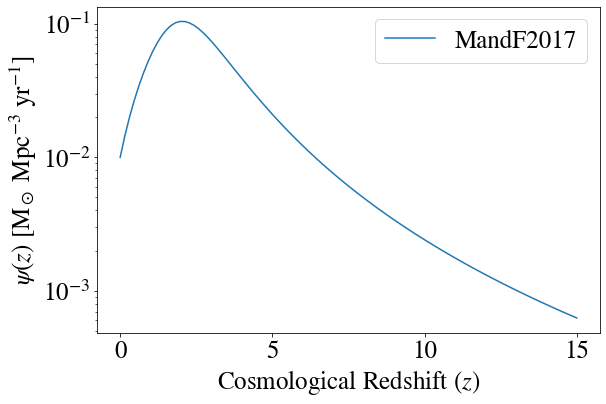

In [15]:
# you can make a plot of the chosen SFRD 
font_value = 25

plt.figure(figsize=(9,6))

z_sfr = np.linspace(zMAX,zMIN,100)

SFR_array = []
for iz in range(len(z_sfr)):
    SFR_array.append(SFR_eval(z_sfr[iz], sfr_args_chosen))

    
if sfrd_interpol_file != False: 
    plt.plot(z_fromtxt, sfr_fromtxt, linewidth = 0, marker = 'o', color = 'red',
            label = sfrd_interpol_file)
    
    
    
    
p = plt.plot(z_sfr, SFR_array,
             label = SFRD_model)
color_p = p[0].get_color()

plt.xlabel(r'Cosmological Redshift ($z$)',fontsize = font_value)
plt.ylabel(r'$\psi(z)$ [M$_\odot$ Mpc$^{-3}$ yr$^{-1}$]',
          fontsize = font_value)
plt.yscale('log')
plt.tick_params(axis='both', which='both', labelsize=font_value)
plt.legend(fontsize = font_value)
plt.savefig(path_out+'/SFRD_plot_'+sim_name+'_'+SFRD_save+'.pdf', format = 'pdf')
if print_opt == 'Yes':
    plt.show()
plt.close()

In [16]:
%load_ext autoreload
%autoreload 2
import cosmo_functions as cf


# check if metallicity are given in ascending order!
if sorted(Z_simulated) != Z_simulated:
    print("metallicities are not properly sorted")
    raise



##########################################################################
# What follows is the main script of cosmoRate. 
# This script gives as output a file .dat where the first
# column is the middle of the redshift bin,
# and the second  column the merger rate density (MRD) [Gpc^{-3}yr^{-1}].
# Further columns are always the MRD evlauted for uncertainty estimation.
###########################################################################

# creating the binning in redshift and time
bin_z = z_hist[0:len(z_hist)-1]-z_hist[1:len(z_hist)]
bin_t1 = sorted(np.array(Planck.lookback_time(z_hist)/u.Gyr*1e9))# in yrs 
bin_t = bin_t1

for k in range(len(cb_class)):  # loop over compact object type
    # check if the output folder exists:
    location = path_out+cb_class[k] 
    if not os.path.exists(location):
        print('creating output folder based on compact object class')
        os.mkdir(location)
    
    
    print('Astrophysical model: ', cb_class[k], sim)
    ############################
    # read the input catalogues
    ############################
    # initialise
    td_Z_sim = []
    data_Z_sim = []
    mtot_Z_sim = []
    # read time delays and other parameters from catalogues
    for Z_sim in Z_simulated:
        print(Z_sim)
        data_Z_read = np.loadtxt(
           input_folder+'/data_'+cb_class[k]+'_'+str(Z_sim)+extension, skiprows=1, usecols = np.arange(0,len(parameters)+1,1))
        data_Z_sim.append(data_Z_read[:, 1:len(parameters)+1])
        td_Z_sim.append(data_Z_read[:, 0])
        mtot_is_0 = np.loadtxt(input_folder+'/data_' +
                               cb_class[k]+'_'+str(Z_sim)+extension, usecols=0)
        mtot_Z_sim.append(mtot_is_0[0])

    # compute merger efficiency.
    # The binary fraction (fbin) and the IMF parameter (fimf) need to be specified in the input file
    eta_known = [np.array(len(td_Z_sim[q]))/np.array(mtot_Z_sim[q])
                 * fbin*fimf for q in range(len(td_Z_sim))]

    # if option activated, use an interpolation on missing metallicities
    if eta_interpol_c == 'Yes':
        [eta, Z_list] = cf.eta_interpol(Z_interpol, Z_simulated, eta_known)

        [td_Z, data_Z] = cf.sort_catalogues(
            Z_list, Z_simulated, td_Z_sim, data_Z_sim)
    else:
        eta = eta_known
        Z_list = Z_simulated
        td_Z = td_Z_sim
        data_Z = data_Z_sim

    # This contains the values of the merger rate densities for each realisation
    MR_z = np.zeros((len(z_hist)-1, N_iter))

    # These contains the observational quantities that are used to evaluate the cosmic MRD.
    # Values for the model of averaged metallicity and SFR. These values correspond to the median
    # Model and references in cosmo_input.py
    met_slope = met_slope_avg*np.ones(N_iter)
    met_inter = np.log10(met_inter_avg)*np.ones(N_iter)
    sfr_norm = 10**(sfr_avg)*np.ones(N_iter)

    # Prepare the metallicity array used to evaluate the probability distributions of metallicities
    # two metallicity extremes are defined such that the sum of all probabilities is always one
    # (in log-sun sale since sigma_met is in log-sun scale)
    Z_max_z = metz(z_hist[len(z_hist)-1], met_slope[0], met_inter[0], sigma_met)
    Z_max_spread_log_sun = Z_max_z+1000*sigma_met
    Z_min_z = metz(z_hist[0], met_slope[0], met_inter[0],sigma_met)
    Z_min_spread_log_sun = Z_min_z-1000*sigma_met

    # Z_list is transformed in log-sun scale
    Z_log_sun = np.log10(Z_list)-np.log10(Z_sun)

    # This contains the metallicity value that are used to evaluate the metallicity probability distribution
    X_prob = np.zeros(len(Z_list)+1)
    # The first and the last values are the metallicity extrems
    X_prob[0] = Z_min_spread_log_sun
    X_prob[len(Z_list)] = Z_max_spread_log_sun
    for i in range(len(Z_list)-1):
        X_prob[i+1] = Z_log_sun[i]+(Z_log_sun[i+1]-Z_log_sun[i])/2
        
    # Here is resampling values depending on assumptions on metallicity evolution and star formation rate uncertainty
    if met_uncertainty == 'Yes':
        if N_iter <= 1:
            print('select more iterations!')
            raise
        for i in range(1, N_iter):
            met_slope[i] = gauss(met_slope_avg, met_slope_sprd)
            met_inter[i] = np.log10(gauss(met_inter_avg, met_inter_sprd))

    if sfr_uncertainty == 'Yes':
        
        # here you add the feature for the uncertainty with A-sloth
        # sfr_norm must be a fixed number, what changes is SFR_eval

        if N_iter <= 1:
            print('select more iterations!')
            raise
        for i in range(1, N_iter):
            sfr_norm[i] = 10**(gauss(sfr_avg, sfr_sprd))

    # Saving in a file the sampled parameters. This are going to be useful if cosmoRate has to sample from a percentile value
    #location = path_out+cb_class[k]+'/'
    filename_par = '/Sampled_parameters_'+str(len(Z_list))+'Z_'+str(fbin_save)+'_'+eta_interpol_c+'_'+metmod_type+'_'+str(
        sigma_met)+'_'+met_uncertainty+'_'+sfr_uncertainty+'_'+bin_save+'_'+SFRD_save+'_'+str(n_paral)+'.dat'
    head = 'met_slope'+' '+'met_inter'+' '+'sfr_norm[Msun Mpc-3 yr-1]'
    np.savetxt(location+filename_par,
               np.transpose([met_slope, met_inter, sfr_norm]), header=head,
              comments = '#')

    # here I am selecting in which case to show the progress bar
    # if you don't want it just put any variable to True
    if N_iter == 1:
        disable_c = True
        disable_c_in = False
    else:
        disable_c = False
        disable_c_in = True
    
    if (mrd_eval == 'Yes'):
        print('evaluating merger rate density')
        # If options are disbaled, loop done only once for the median values of the models.

            
        for i in tqdm(range(N_iter), disable = disable_c):
            
            # THIS IS BAD CODING! YOU SHOULD PUT IT OUTSIDE THE LOOP!  
            if SFRD_model == 'MandF2017':
                sfr_args_chosen = sfr_norm[i] 
                
            elif SFRD_model == 'A-sloth_uncrt':
                
                sfr_fromtxt = sfr_fromtxt_all[i,:]
                

                
                sfr_args_chosen = interp1d(z_fromtxt, sfr_fromtxt, bounds_error = False,
                                         fill_value='extrapolate')
            
            # compute the merger rate densities (MRD). The quantity v is the number of mergers per Gpc-3 and
            # It depends on merger redshift, formation redshift and metallicity
            [MRD, v] = cf.merger_rate_density(
                metz, bin_z, z_hist, X_prob, bin_t, td_Z, eta, met_slope[i], met_inter[i], sfr_norm[i], 
                sigma_met,
                disable_c_in, SFR_eval, sfr_args_chosen)
            # store merger rate density
            MR_z[:, i] = MRD[::-1]
            
        # Save MRD in output file
        head = "Redshift"+" "+"Merger_Rate_Density[Gpc^-3yr^-1]"
        filename = '/MRD_spread_'+str(len(Z_list))+'Z_'+str(fbin_save)+'_'+eta_interpol_c+'_'+metmod_type+'_'+str(
        sigma_met)+'_'+met_uncertainty+'_'+sfr_uncertainty+'_'+bin_save+'_'+SFRD_save+'_'+str(n_paral)+'.dat'

        # Column 0: merger redshift, Column >=1: Merger Rate Density
        MR_z_save = np.zeros((len(z_hist)-1, N_iter+1))
        for c in range(len(z_hist)-1):
            MR_z_save[c, :] = np.hstack(
            [z_hist[::-1][c]+bin_z[::-1][c]/2, MR_z[c, :]])
        np.savetxt(location+filename, MR_z_save, header=head,
                  comments = '#')
        
    # if catalog option is activated, produce catalogs of merging compact objects in various redshift bins
    if catalogues_c == 'Yes':
        print('creating catalogs with',N_cat,'merging compact objects per each redshift bin')
        if (perc_input == 50):
            v_chosen = v
            met_unc_zperc = met_uncertainty
            sfr_unc_zperc = sfr_uncertainty
        # if you want to sample from a value which is different from the median you have to evaluate the uncertianty on MRD.
        elif (perc_input != 50):
            N_iter_cat = np.ones(n_paral_cat, dtype = int)*N_iter_par
            filename_cat = []
            filename_par = []
            core_filename = str(len(Z_list))+'Z_'+str(fbin_save)+'_'+eta_interpol_c+'_'+metmod_type+'_'+str(sigma_met)+'_'
            semi_filename_par = '/Sampled_parameters_'+core_filename
            semi_filename_ind =  '/Figure_'+core_filename
            # if you are evaluating the uncertainty this time 
            if (met_uncertainty == 'Yes') or (sfr_uncertainty == 'Yes'):
                filename_cat.append(filename)
                filename_par.append(semi_filename_par+met_uncertainty+'_'+sfr_uncertainty+'_'+bin_save+'_'+SFRD_save+'_'+str(n_paral)+'.dat')
                filename_ind = semi_filename_ind+met_uncertainty+'_'+sfr_uncertainty+'_'+bin_save+'_'+SFRD_save+'_'+str(n_paral)+'.pdf'
            # if you are not evaluating the uncertainty this time
            if (met_uncertainty == 'No') and (sfr_uncertainty == 'No'):
                filename_ind = semi_filename_ind+met_unc_cat+'_'+sfr_unc_cat+'_'+bin_save+'_'+SFRD_save+'_'+str(n_paral_cat)+'.pdf'
                for pp in range(n_paral_cat):
                    filename_cat.append('/MRD_spread_'+core_filename+met_unc_cat+'_'+sfr_unc_cat+'_'+bin_save+'_'+SFRD_save+'_'+str(pp)+'.dat')                
                    filename_par.append(semi_filename_par+met_unc_cat+'_'+sfr_unc_cat+'_'+bin_save+'_'+SFRD_save+'_'+str(pp)+'.dat')

            MR_z_read = np.loadtxt(
                location+filename_cat[0], usecols = range(1,N_iter_cat[0]+1)) 
            obs_param = np.loadtxt(
                location+filename_par[0])    
            for ll in range(1,len(filename_cat)):
                MR_z_read = np.hstack((MR_z_read,np.loadtxt(
                location+filename_cat[ll],usecols = range(1,N_iter_cat[ll]+1))))
                obs_param = np.vstack((obs_param, np.loadtxt(
                location+filename_par[ll])))             
            
            N_iter_cat_sum  = sum(N_iter_cat)
            if N_iter_cat_sum != len(obs_param[:,0]):
                print('There is a problem in reading the catalogs!')
                raise

            # Find the closest merger rate density
            MRD_perc = np.zeros(len(z_hist)-1)
            diff_array = np.zeros((len(z_hist)-1, N_iter_cat_sum))
            for zz in range(len(z_hist)-1):
                MRD_perc[zz] = np.percentile(MR_z_read[zz, :], perc_input)
                for mm in range(N_iter_cat_sum):
                    sigma2 = 1/(1+z_hist[zz])**2
                    diff_array[zz,mm] = (MRD_perc[zz]-MR_z_read[zz,mm])**2/sigma2
            chi_find = np.zeros(N_iter_cat_sum)
            for nn in range(N_iter_cat_sum):
                chi_find[nn] = np.sum(diff_array[:,nn])            
            ind_samp = np.argmin(chi_find) 
            
            # I evaluate again the merger rate density with the chosen parameters on metallicity and star formation rate
            [met_slope_ind, met_inter_ind, sfr_norm_ind] = obs_param[ind_samp, :]
            [MRD_chosen, v] = cf.merger_rate_density(
                metz, bin_z, z_hist, X_prob, bin_t, td_Z, eta, 
                met_slope_ind,  met_inter_ind, sfr_norm_ind, sigma_met,
                disable_c_in, SFR_eval, sfr_args_chosen)
            # saving the MRD at that percentile
            np.savetxt(location+'/MRD_spread_'+core_filename+met_unc_cat+'_'+sfr_unc_cat+'_'+bin_save+'_'+SFRD_save+'_'+str(perc_input)+'_'+str(n_paral)+'.dat',
                       np.transpose([z_hist[1:][::-1]+bin_z[::-1]/2, MRD_perc]), header = 'Redshift MRD[Gpc^-3yr^-1]',
                      comments = '#')
            
            # Creating the figure to check if we are sampling from a meaningful distribution
            font_value = 25
            fig1 = plt.figure(figsize=(9,6))
            frame1=fig1.add_axes((.1,.3,.8,.6))
            ind_z_hist = z_hist[1:] < 10
            plt.plot(z_hist[1:][ind_z_hist], MRD_chosen[ind_z_hist], 
                     label = 'Closest realisation')
            plt.plot(z_hist[1:][ind_z_hist], MRD_perc[::-1][ind_z_hist], 
                     label = str(perc_input)+' percentile', linestyle = '--')
            plt.ylabel(r'$\mathcal{R}_{\rm{'+cb_class[k]+'}} $ [Gpc$^{-3}$ yr$^{-1}$]',
                      fontsize = font_value)
            plt.annotate('met slope = '+str(round(met_slope_ind,4))
        +'\nmet interc = '+str(round(met_inter_ind,4))+'\nsfr norm = '+
        str(round(sfr_norm_ind,4)), xy = [0.1,0.1], xycoords = 'axes fraction',
                        fontsize = font_value)
            plt.legend(fontsize = font_value)
            plt.tick_params(axis='both', which='both', labelsize=font_value)
            # residual subplot
            frame2=fig1.add_axes((.1,.1,.8,.2))
            residual = (MRD_chosen[ind_z_hist] - MRD_perc[::-1][ind_z_hist])/MRD_perc[::-1][ind_z_hist]*100
            plt.plot(z_hist[1:][ind_z_hist], residual, color = 'black')
            plt.xlabel(r'Cosmological Redshift ($z$)', fontsize = font_value)
            plt.ylabel('Residual %', fontsize = font_value)
            plt.tick_params(axis='both', which='both', labelsize=font_value)
            plt.savefig(location+filename_ind, format = 'pdf')
            if print_opt == 'Yes':
                plt.show()
            plt.close()
            # this variables are needed to correctly save the metallicity percentage distribution
            met_unc_zperc = met_unc_cat
            sfr_unc_zperc = sfr_unc_cat

        # once v is provided, the catalog of merging compact binaries can be created
        if z_vect_cat_op == False:
            z_vect_cat = z_hist[0:-1]-bin_z/2 #z_hist[0:-1] 
        else:
            z_vect_cat = z_vect_cat_op
        
        
        Zperc = cf.catalogues(z_hist, z_vect_cat, bin_z, Z_list, v, N_cat,
                              td_Z, data_Z, parameters, location, cb_class[k], sim_name, SFRD_save, N_figures, perc_input,
                              SFR_eval, sfr_args_chosen, sampling, verbose, bin_t)

        
        # Column 0: merger redshift, Column from 1 to len(Z_list)-1:Metallicity percentage, Column len(Z_list): sum of the percentages
        Zperc_comp = np.zeros((len(z_vect_cat), len(Z_list)+2))
        # I am summing over formation redshift for the moment 
        for a in range(len(z_vect_cat)):
            Zperc_comp[a, :] = np.hstack(
                [z_vect_cat[::-1][a], 
                 np.sum(Zperc[::-1][a, :, :], axis = 0), 
                 np.sum(Zperc[::-1][a,:, :], axis = None)])

        filename_Zperc = '/Zperc_z_'+str(len(Z_list))+'Z_'+str(fbin_save)+'_'+eta_interpol_c+'_'+metmod_type+'_'+str(
            sigma_met)+'_'+met_unc_zperc+'_'+sfr_unc_zperc+'_'+bin_save+'_'+SFRD_save+'_'+str(perc_input)+'_'+str(n_paral)+'_'+sampling+'.dat'
        head_Zperc = 'Redshift'+' '+str(Z_list)+' '+'Total_percentage'
        np.savetxt(location+filename_Zperc, Zperc_comp,
                   header=head_Zperc, fmt='%f', comments = '#')

# end of cosmoRate :)

print('end of cosmoRate')

Astrophysical model:  BBHs popI_II/A3/
0.0002
0.0004
0.0008
0.0012
0.0016
0.002
0.004
0.006
0.008
0.012
0.016
0.02
evaluating merger rate density


100%|███████████████████████████████████████████| 99/99 [00:07<00:00, 12.90it/s]

end of cosmoRate


In [17]:
def merge_rate_unc(merger_rate, quant_low, quant_up):
    #------------------------------------
    # This function evaluates the median and N% credible interval of the merger rate density
    # if the option on the uncertainty is activated.
    # the first quantity is a matrix len(P)xlen(R) where len(P) are the number of redshift bins
    # and len(R) = N_iter
    # quant_low is the lowst quantile and quant_up is highest quantile, that is 
    # to evaluate the 50% credible interval, quant_low = 25 and quant_up = 75
    #------------------------------------
    
    MR_50 = np.zeros(len(merger_rate[:,0]))
    MR_low = np.zeros(len(merger_rate[:,0]))
    MR_up = np.zeros(len(merger_rate[:,0]))
    
    for i in range(len(MR_50)):
        MR_50[i] = np.percentile(merger_rate[i,:], 50)
        MR_low[i] = np.percentile(merger_rate[i,:], quant_low)
        MR_up[i] = np.percentile(merger_rate[i,:], quant_up)
    
    return MR_50, MR_low, MR_up
    

No handles with labels found to put in legend.


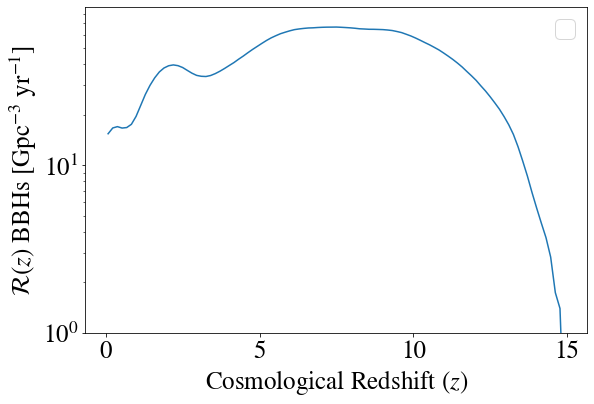

In [18]:
if mrd_eval == 'Yes':
    font_value = 25
    
    plot_delay = False
    
    for k in range(len(cb_class)):
        # one figure per each compact object
        plt.figure(figsize=(9,6))

        if (met_uncertainty == 'Yes') or (sfr_uncertainty == 'Yes') or (SFRD_model == 'A-sloth_uncrt'):
            
            z_binz = np.loadtxt(path_out+cb_class[k]+filename, usecols = 0)
            
            MRD_binz = np.loadtxt(path_out+cb_class[k]+filename, usecols = np.arange(1,N_iter))

            
            CI = '95'
            if CI == '95':
                min_ci = 2.5
                max_ci  = 97.5
            elif CI == '50':
                min_ci = 25
                max_ci  = 75
                
            MR_50, MR_low, MR_up = merge_rate_unc(MRD_binz, min_ci, max_ci)

            p = plt.plot(z_binz, MR_50,  label = 'median '+sim_name)
            color_p = p[0].get_color()
            ind_min = 0
            plt.fill_between(z_binz[ind_min:], MR_low[ind_min:], MR_up[ind_min:],  label = CI+'% C.I. '+sim_name, alpha = 0.5,
                            color = color_p)
            
            if SFRD_model == 'A-sloth_uncrt':
                z_true, MRD_true = np.loadtxt(path_out+cb_class[k]+'/MRD_spread_1Z_100_No_MandF2017_0.2_No_No_False_asloth_smooth_off_0.dat',
                                             unpack = True)
            else:
                MRD_true = np.loadtxt(path_out+cb_class[k]+filename, usecols = 1)
            plt.plot(z_true[ind_min:], MRD_true[ind_min:],  label = 'expected '+sim_name,color = color_p, linestyle = '--')

        else:
            [z_binz, MRD_binz] = np.loadtxt(path_out+cb_class[k]+filename, unpack = True)
            ind_z = z_binz < zMAX
            if plot_delay == True:
                plt.plot(Planck.lookback_time(z_binz[ind_z]), MRD_binz[ind_z], label = sim_name)
            else:
                plt.plot(z_binz[ind_z], MRD_binz[ind_z], label = sim_name)        
        
        if plot_delay == True:
            plt.xlabel(r'Lookback time [Gyr]',fontsize = font_value)
        else:
             plt.xlabel(r'Cosmological Redshift ($z$)',fontsize = font_value)
        
        plt.ylabel(r'$\mathcal{R}(z)$ '+cb_class[k]+' [Gpc$^{-3}$ yr$^{-1}$]',
                  fontsize = font_value)
        plt.tick_params(axis='both', which='both', labelsize=font_value)
        plt.yscale('log')
        
        if pop == 'I-II':
            selected_bottom = 1e0
        elif pop == 'III':
            selected_bottom = 1e-4
        
        plt.ylim(bottom=selected_bottom)
        plt.legend(fontsize = font_value, ncol = 2,
                  handlelength=2.0)
        plt.savefig(location+'/MRD_plot_'+sim_name+'_'+cb_class[k]+'_'+SFRD_save+'_'+sampling+'.pdf', format = 'pdf')        
        if print_opt == 'Yes':
            plt.show()
        plt.close()
        
        

In [19]:
# catalogs plots
if catalogues_c == 'Yes':
    # number of redshif bins  
    if pop == 'III':
        if sim_name == 'all_z_bins':
            z_plot = [20.0, 11.02, 5.01, 0.12]
        else:
            z_plot = [20, 11, 5, 0.1] 
    elif pop == 'I-II':
        if SFRD_model == 'MandF2017':
            #z_plot = [10.0, 4.09, 1.06, 0.15] 
            z_plot = [10.08, 4.02, 1.14, 0.08] 
        elif SFRD_model == 'Harikane22':
            z_plot = [10.47, 4.03, 1.07, 0.13] 
    
    ncolors = len(z_plot)
    viridis = cm.get_cmap('viridis', ncolors+1)
    divid = np.linspace(0, 1, ncolors+1)
    color_z = viridis(divid)    
    fig, axs = plt.subplots(figsize=(9,6))    
    
    for i in range(len(z_plot)):
        
        #ind_z_plot = np.argmin(np.abs(z_plot[i]-z_binz))
        #print(z_binz)
        #print(z_binz[ind_z_plot])
        m1, m2 = np.loadtxt(path_out+cb_class[k]+'/'+cb_class[k]+'_'+\
                            sim_name+'_'+SFRD_save+'_z'+str(z_plot[i])+'_'+str(perc_input)+'_'+sampling+'.dat',
                           usecols = (1,2), unpack = True)
        
        ####################
        # WARNING!
        # check always if masses are in the correct order
        ####################
        swaps = 0
        for y in range(len(m1)):
            if m2[y] > m1[y]:
                temp = m1[y]
                m1[y] = m2[y]
                m2[y] = temp
                swaps += 1
        if swaps != 0:
            print('masses were not ordered before being processed with cosmoRate')
                
        z_label = z_plot[i]#z_hist[len(z_hist)-bin_z_plot[i]]-bin_z[len(z_hist)-bin_z_plot[i]]/2
        
        n_m_bins = 50
        if pop == 'III':
            m_bins = np.logspace(np.log10(min(m1)), np.log10(max(m1)), n_m_bins)
            axs.set_yscale('log')
        elif pop == 'I-II':
            m_bins = np.linspace(min(m1), max(m1), n_m_bins)
        else:
            print('select population!')
        
        axs.hist(m1, bins = m_bins, density = True, 
                 label = r'$z=$'+str(round(z_label,1)), histtype = 'step',
                color = color_z[i])
        
    axs.set_xlabel(r'$m_1 ~[{\rm{M}}_\odot$]',fontsize = font_value)
    axs.set_ylabel(r'PDF '+cb_class[k],fontsize = font_value)
    
    axs.set_yscale('log')
    if pop == 'III':
        axs.set_xscale('log')
    axs.tick_params(axis='both', which='both', labelsize=font_value)
        
    plt.legend(fontsize = font_value/1.2, ncol = 2)
    plt.savefig(location+'/m1_dist_'+sim_name+'_'+cb_class[k]+'_'+SFRD_save+'_'+sampling+'.pdf', format = 'pdf')
    if print_opt == 'Yes':
        plt.show()
    plt.close()
    
    
    
    
    # plot formation redshift distribution
    fig, axs = plt.subplots(figsize=(9,6))    
    for i in range(len(z_plot)):
        
        z_form = np.loadtxt(path_out+cb_class[k]+'/'+cb_class[k]+'_'+\
                            sim_name+'_'+SFRD_save+'_z'+str(z_plot[i])+'_'+str(perc_input)+'_'+sampling+'.dat',
                           usecols = len(parameters)+1, unpack = True)
        
        z_label = z_plot[i]#z_hist[len(z_hist)-bin_z_plot[i]]-bin_z[len(z_hist)-bin_z_plot[i]]/2
        #print(z_label)
        
        z_bins = np.linspace(zMIN,zMAX,30)
        
        axs.hist(z_form, bins = z_bins, density = True, 
                 label = r'$z_{\rm{merg}}=$'+str(round(z_label,1)), histtype = 'step',
                color = color_z[i])
    
    axs.set_xlabel(r'$z_{\rm{form}}$',fontsize = font_value)
    axs.set_ylabel(r'PDF '+cb_class[k],fontsize = font_value)
    axs.set_yscale('log')
    axs.tick_params(axis='both', which='both', labelsize=font_value)
        
    if pop == 'III':
        if sfrd_interpol_file == True:
            axs.plot(z_fromtxt_first, 1e-3, marker = 'o', color = 'red', markersize = 10,
                label = r'$z_{\rm{min}}$ of SFR')
            axs.set_ylim(bottom = 1e-3)
        
    plt.legend(fontsize = font_value/1.2, ncol = 2)
    plt.savefig(location+'/z_form_dist_'+sim_name+'_'+cb_class[k]+'_'+SFRD_save+'_'+sampling+'.pdf', format = 'pdf')
    if print_opt == 'Yes':
        plt.show()
    plt.close()
    
    

In [20]:
# always create the python version of this notebook 
!jupyter nbconvert --to script cosmo_rate_notebook.ipynb

[NbConvertApp] Converting notebook cosmo_rate_notebook.ipynb to script
[NbConvertApp] Writing 43720 bytes to cosmo_rate_notebook.py
